In [10]:
import torch, torchvision
from src.utils import NIPS2017TargetedDataset
from src.layers import Flow
from src.losses import adv_loss
from kornia import tensor_to_image as t2i
import matplotlib.pyplot as plt
import tqdm

In [11]:
dset = NIPS2017TargetedDataset("data/nips2017_targeted")

net = torchvision.models.inception_v3().cuda()
net.load_state_dict(torch.load("models/inception_v3_google-1a9a5a14.pth"))
net.eval()



/opt/conda/lib/python3.8/site-packages/torchvision/models/inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [12]:
data = dset[0]

img = data["image"].cuda().unsqueeze(0)
true_class = data["true_class"]
target_class = data["target_class"]

In [27]:
flow_layer = Flow(299, 299, parameterization=None).to("cuda")
optimizer = torch.optim.Adam(flow_layer.parameters(), lr=0.1)

K = 0
for n in tqdm.tqdm(range(200)):
    # flowed_img = src.utils.flow_uv(img, flow_layer)
    flowed_img = flow_layer(img)
    out = net(flowed_img * 2 - 1)[0]
    loss = adv_loss(out, target_class, K)
    if loss.item() <= K:
        break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  4%|▍         | 9/200 [00:00<00:11, 17.19it/s]


Text(0.5, 1.0, 'Spatially Transformed Image: Classified as 778')

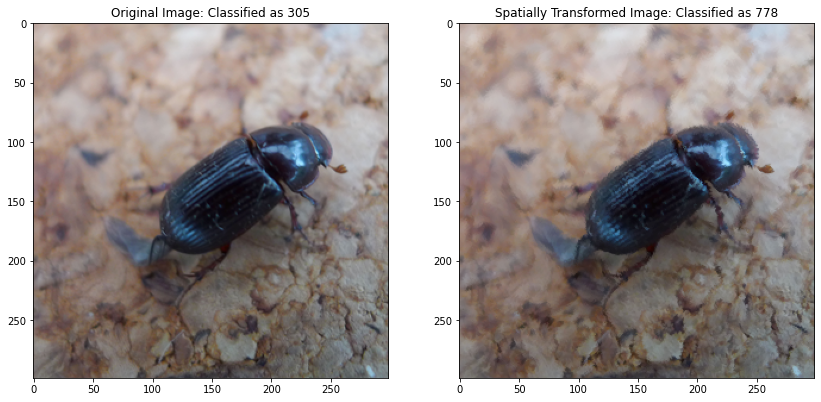

In [29]:

flowed_img = flow_layer(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,14))
ax1.imshow(t2i(img))
ax1.set_title(f'Original Image: Classified as {true_class}')
ax2.imshow(t2i(flowed_img))
ax2.set_title(f'Spatially Transformed Image: Classified as {target_class}')